# Setup 

In [1]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import datetime

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

# Initialize the GPU and Test GPU

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2025-12-03 16:34:26.529645: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-03 16:34:26.529665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-03 16:34:26.529670: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-03 16:34:26.529681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 16:34:26.529689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Import Images

In [4]:
PATH_POSITIVE = os.path.join('data', 'positive')
PATH_NEGATIVE = os.path.join('data', 'negative')
PATH_ANCH = os.path.join('data', 'anch')

In [5]:
os.mkdir(PATH_POSITIVE)
os.mkdir(PATH_NEGATIVE)
os.mkdir(PATH_ANCH)

FileExistsError: [Errno 17] File exists: 'data/positive'

## Move files to the directory

In [ ]:

for directory in os.listdir('lfw/lfw-deepfunneled'):
    for file in os.listdir(os.path.join('lfw/lfw-deepfunneled', directory)):
        PAST_PATH = os.path.join('lfw/lfw-deepfunneled', directory, file)
        NEW_PATH = os.path.join(PATH_NEGATIVE, file)
        os.replace(PAST_PATH, NEW_PATH)
        file_count -= 1
        if file_count <= 0:
            break
    if file_count <= 0:
        break

print("finished moving files")

finished moving files


In [ ]:
pos_file_count = neg_file_count = anch_file_count = 0

for directory in os.listdir('lfw/lfw-deepfunneled'):
    file_c = len(os.listdir(os.path.join('lfw/lfw-deepfunneled', directory)))
    if file_c > 1:
        if file_c % 2 == 1:
            file_c -= 1
        for file in os.listdir(os.path.join('lfw/lfw-deepfunneled', directory)):
            if file_c == 0: break;
            if file_c % 2 == 0:
                PAST_PATH = os.path.join('lfw/lfw-deepfunneled', directory, file)
                NEW_PATH = os.path.join(PATH_POSITIVE, file)
                os.replace(PAST_PATH, NEW_PATH)
                pos_file_count += 1
                file_c -= 1 
            else: 
                PAST_PATH = os.path.join('lfw/lfw-deepfunneled', directory, file)
                NEW_PATH = os.path.join(PATH_ANCH, file)
                os.replace(PAST_PATH, NEW_PATH)
                anch_file_count += 1
                file_c -= 1
                
    else:
        for file in os.listdir(os.path.join('lfw/lfw-deepfunneled', directory)):
            PAST_PATH = os.path.join('lfw/lfw-deepfunneled', directory, file)
            NEW_PATH = os.path.join(PATH_NEGATIVE, file)
            os.replace(PAST_PATH, NEW_PATH)
            neg_file_count += 1

print(f"finished moving pos: {pos_file_count}")
print(f"finished moving neg: {neg_file_count}")
print(f"finished moving anch: {anch_file_count}")

finished moving pos: 4042
finished moving neg: 4069
finished moving anch: 4042


In [7]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    #resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [9]:
anchor = tf.data.Dataset.list_files(PATH_ANCH+'/*.jpg', shuffle=False).take(4042)
positive = tf.data.Dataset.list_files(PATH_POSITIVE+'/*.jpg', shuffle=False).take(4042)
negative = tf.data.Dataset.list_files(PATH_NEGATIVE+'/*.jpg', shuffle=False).take(4042)

triplets = tf.data.Dataset.zip((anchor, positive, negative))

In [10]:
def preprocess_triplets(input_img, pos_img, neg_img):
    return (
        preprocess(input_img), 
        preprocess(pos_img), 
        preprocess(neg_img)
    )

data = triplets.map(preprocess_triplets)
data = data.cache()
data = data.shuffle(buffer_size=1024)

# Training partition (70%)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(18)
train_data = train_data.prefetch(9)

# Testing partition (30%)
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(18)
test_data = test_data.prefetch(9)

print(f"Triplet Pipeline complete.")
print(f"Training Batches: {len(train_data)}")
print(f"Testing Batches: {len(test_data)}")

Triplet Pipeline complete.
Training Batches: 158
Testing Batches: 68


In [11]:
# Grab one batch of data
samples = train_data.as_numpy_iterator()
samp = samples.next()

# samp[0] is input image batch, samp[1] is validation image batch, samp[2] is labels
print("Image Batch Shape:", samp[0].shape) 
print("Label Batch Shape:", samp[2].shape)

Image Batch Shape: (18, 100, 100, 3)
Label Batch Shape: (18, 100, 100, 3)


2025-12-03 16:03:44.089963: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


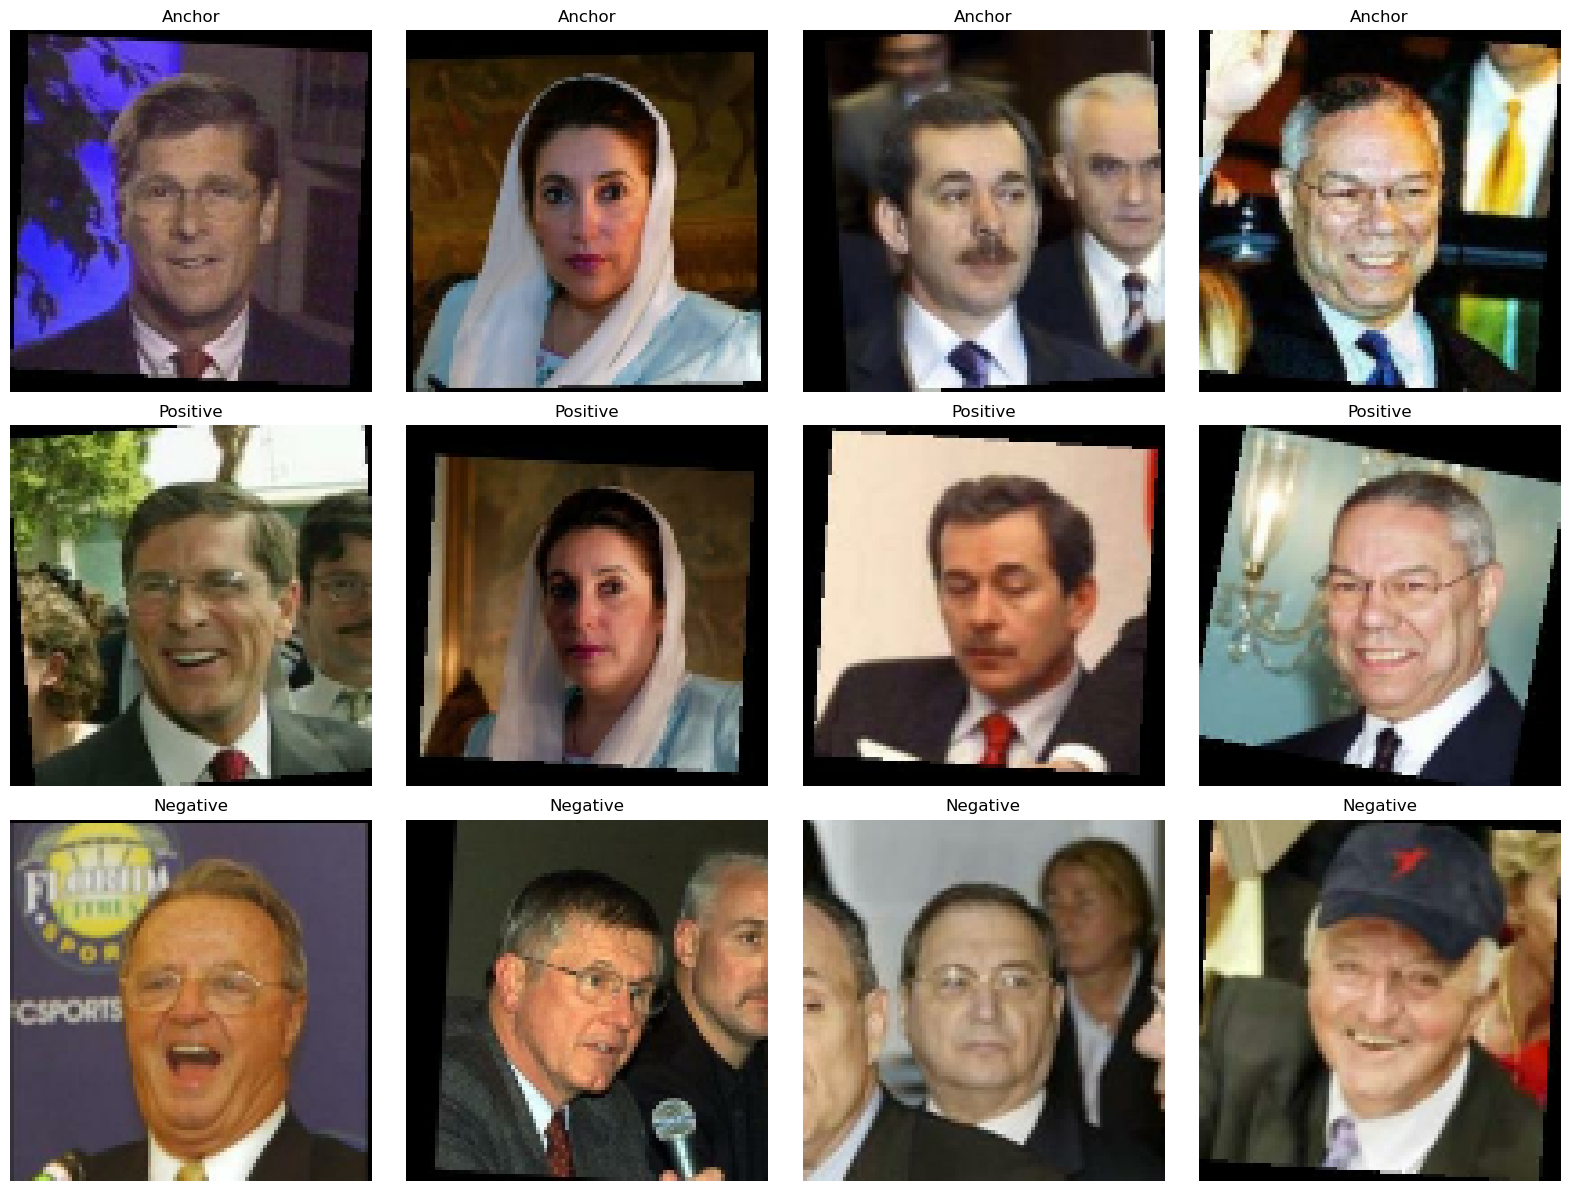

In [ ]:
anchor_batch, pos_batch, neg_batch = train_data.as_numpy_iterator().next()

# Setup the subplot grid (3 rows, 4 columns)
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16, 12))

for i in range(4):
    # Row 1: Anchor
    axs[0, i].imshow(anchor_batch[i])
    axs[0, i].set_title('Anchor')
    axs[0, i].axis('off')
    
    # Row 2: Positive
    axs[1, i].imshow(pos_batch[i])
    axs[1, i].set_title('Positive')
    axs[1, i].axis('off')

    # Row 3: Negative
    axs[2, i].imshow(neg_batch[i])
    axs[2, i].set_title('Negative')
    axs[2, i].axis('off')

plt.tight_layout()
plt.show()

In [14]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First Block
    c1 = Conv2D(32, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second Block
    c2 = Conv2D(64, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third Block 
    c3 = Conv2D(64, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Fourth Block
    c4 = Conv2D(128, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    
    # Dense Layer (No activation for Triplet Loss)
    d1 = Dense(4096, activation=None)(f1) 
    
    # FIXED: outputs=d1 (not [d1])
    return Model(inputs=[inp], outputs=d1, name='embedding') 

embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 91, 91, 32)     │         9,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 40, 40, 64)     │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 17, 17, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    18,878,464 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,185,312 (73.19 MB)

 Trainable params: 19,185,312 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
def make_siamese_triplet_model():
    input_anchor = Input(name='input_anchor', shape=(100,100,3))
    input_positive = Input(name='input_pos', shape=(100,100,3))
    input_negative = Input(name='input_neg', shape=(100,100,3))
    
    # Re-instantiate the embedding model to ensure clean weights
    embedding = make_embedding()
    
    emb_a = embedding(input_anchor)
    emb_p = embedding(input_positive)
    emb_n = embedding(input_negative)
    
    # Concatenate the three embeddings
    out = tf.keras.layers.Concatenate()([emb_a, emb_p, emb_n])
    
    return Model(inputs=[input_anchor, input_positive, input_negative], outputs=out, name='SiameseTriplet')

siamese_triplet = make_siamese_triplet_model()
siamese_triplet.summary()

Model: "SiameseTriplet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_anchor        │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_pos           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_neg           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 19,185,312 │ input_anchor[0][… │
│ (Functional)        │                   │            │ input_pos[0][0],  │
│                     │                   │            │ input_neg[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12288)     │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding[1][0],  │
│                     │                   │            │ embedding[2][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,185,312 (73.19 MB)

 Trainable params: 19,185,312 (73.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Custom Triplet Loss Function
def triplet_loss(y_true, y_pred):
    # Hyperparameter: Margin
    margin = 0.5
    
    emb_size = 4096
    anchor = y_pred[:, 0:emb_size]
    positive = y_pred[:, emb_size:2*emb_size]
    negative = y_pred[:, 2*emb_size:]
    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    
    # triplet Loss
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.maximum(basic_loss, 0.0)
    
    return tf.reduce_mean(loss)

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

# 2. Setup Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_triplet)

# Ensure the directory exists
os.makedirs(checkpoint_dir, exist_ok=True)

In [18]:
@tf.function
def train_step(batch):
    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        
        # Get anchor, positive, negative from the batch tuple
        # batch is a tuple: (anchor_batch, positive_batch, negative_batch)
        
        # Forward pass:
        # Pass the batch (list of 3 tensors) to the model to get the concatenated embeddings
        y_pred = siamese_triplet(batch, training=True)
        
        # Calculate loss:
        # y_true is irrelevant here because the structure implies the labels, 
        # so we pass None or dummy data. The loss is calculated purely from y_pred embeddings.
        loss = triplet_loss(None, y_pred)
        
    # Calculate gradients of the loss with respect to the trainable variables
    gradients = tape.gradient(loss, siamese_triplet.trainable_variables)
    
    # Apply gradients to the optimizer (Backpropagation)
    opt.apply_gradients(zip(gradients, siamese_triplet.trainable_variables))
    
    # Return the current loss to print progress
    return loss

In [ ]:
def train(data, EPOCHS):
    # Setup TensorBoard Logging
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir = os.path.join('logs', 'gradient_tape', current_time)
    summary_writer = tf.summary.create_file_writer(log_dir)
    
    for epoch in range(1, EPOCHS+1):
        print(f'\n Epoch {epoch}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            progbar.update(idx+1, [("loss", loss)])
            
            # Log metrics to TensorBoard
            with summary_writer.as_default():
                # Log Loss every step
                tf.summary.scalar('loss', loss, step=opt.iterations)
                
                # Log Image Examples (First batch of every epoch only)
                if idx == 0:
                    tf.summary.image('Anchor', batch[0], max_outputs=3, step=opt.iterations)
                    tf.summary.image('Positive', batch[1], max_outputs=3, step=opt.iterations)
                    tf.summary.image('Negative', batch[2], max_outputs=3, step=opt.iterations)
            
        if epoch % 3 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# --- RUN TRAINING ---
# Define number of epochs
EPOCHS = 20 

# Start training
# Ensure 'train_data' is the dataset created in the previous steps
train(train_data, EPOCHS)


 Epoch 1/20
 90/158 ━━━━━━━━━━━━━━━━━━━━ 37s 557ms/step - loss: 0.0662

Model saved to 'siamese_embedding_model.h5'
--- Testing Match ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Distance: 1.3898
Result: NO MATCH (Different People)


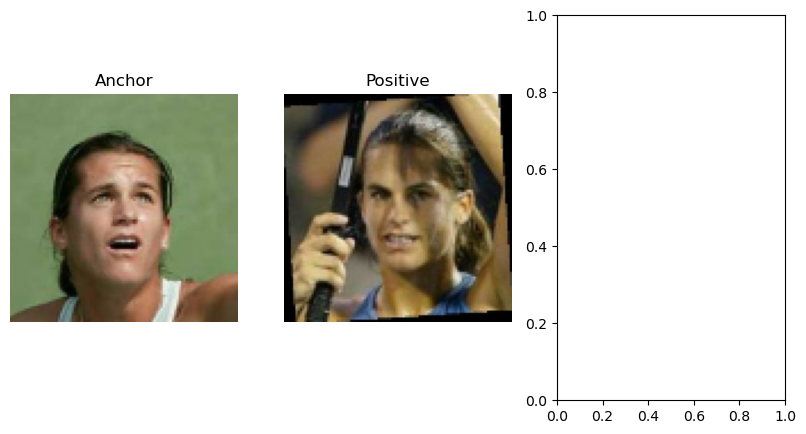

In [70]:
trained_embedding = siamese_triplet.get_layer('embedding')

# Save the embedding model
# This is the model we will use for the app/production to generate vectors
print("Model saved to 'siamese_embedding_model.h5'")


trained_embedding = tf.keras.models.load_model('siamese_embedding_model2.h5')

def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    
    return img

def verify(model, image_path_1, image_path_2, detection_threshold=0.5):
   
    img1 = preprocess(image_path_1)
    img2 = preprocess(image_path_2)
    
    img1_batch = tf.expand_dims(img1, axis=0)
    img2_batch = tf.expand_dims(img2, axis=0)
    
    # 2. Make Predictions (Generate Embeddings)
    embedding1 = model.predict(img1_batch)
    embedding2 = model.predict(img2_batch)
    
    # 3. Calculate Distance
    # Since we used Triplet Loss with Euclidean distance logic, we use L2 norm here
    # (or L1 if you prefer, but Euclidean is standard for Triplet Loss spaces)
    distance = np.linalg.norm(embedding1 - embedding2)
    
    # 4. Render Result
    print(f"Distance: {distance:.4f}")
    
    if distance < detection_threshold:
        print("Result: MATCH (Same Person)")
        return True, distance
    else:
        print("Result: NO MATCH (Different People)")
        return False, distance

# --- 3. Test with Real Images ---
# Replace these paths with actual paths from your 'data' folder to test

# Example: Picking a random anchor and a positive match
test_anchor_path = os.path.join('Test', 'Amelie_Mauresmo_0002.jpg')
test_pos_path = os.path.join('Test', 'Amelie_Mauresmo_0010.jpg')

test_neg_path = os.path.join('data', 'negative', os.listdir(os.path.join('data', 'negative'))[2])

print("--- Testing Match ---")
verify(trained_embedding, test_anchor_path, test_pos_path, detection_threshold=0.6)


# --- 4. Visual Verification ---
# Let's plot the images we just tested to see them
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(preprocess(test_anchor_path))
axs[0].set_title("Anchor")
axs[0].axis("off")

axs[1].imshow(preprocess(test_pos_path))
axs[1].set_title("Positive")
axs[1].axis("off")

plt.show()
